In [1]:
import numpy as np
import itertools
from IPython.display import display, Markdown, Latex, Math

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

import tropical
import data_gen2

import itertools

import time

from scipy.spatial import ConvexHull, Delaunay

In [2]:
def evaluate_trop(Fterms, Gterms, data, dropout_rate):
    
    termsToDropF = np.random.uniform(size=(Fterms.shape[0]))
    termsToDropF = termsToDropF < dropout_rate
    
    termsToDropG = np.random.uniform(size=(Gterms.shape[0]))
    termsToDropG = termsToDropG < dropout_rate
    
    if np.all(termsToDropF):
        termsToDropF[np.random.choice(termsToDropF.shape[0])] = False
        
    if np.all(termsToDropG):
        termsToDropG[np.random.choice(termsToDropG.shape[0])] = False
    
    temp = np.ones((data.shape[0], 1))
    test = np.concatenate((data, temp), axis=1)
    Fresult = np.matmul(Fterms, test.T)
    Fresult[termsToDropF] = float('-inf')
    Fmax = np.amax(Fresult, axis=0)
    Flocs = np.argmax(Fresult, axis=0)

    Gresult = np.matmul(Gterms, test.T)
    Gresult[termsToDropG] = float('-inf')
    Gmax = np.amax(Gresult, axis=0)
    Glocs = np.argmax(Gresult, axis=0)
    
    return Fmax, Gmax, Flocs, Glocs


In [3]:
def rayHullIntersect(index, direction, terms):
    
    shifted_terms = terms - terms[index]
    
    hull = ConvexHull(shifted_terms, qhull_options='Qt')
    
    maxs = np.amax(terms, axis=0)
    mins = np.amin(terms, axis=0)
    bounding_box_volume = np.prod(maxs-mins)
            
    
    if hull.volume > bounding_box_volume:
        print(maxs, mins)
        print(hull.volume, bounding_box_volume)
        return 0
    if index in hull.vertices:
        return 0
    
    eq = hull.equations.T
    V, b = eq[:-1], eq[-1]
    alpha = -b/np.dot(V.T,direction)
    
    if len(alpha[alpha>0]) > 0:
        return np.amin(alpha[alpha>0])
    else:
        return 0

In [4]:
def rayHullIntersect2(index, direction, terms):
    
    hull = ConvexHull(terms, qhull_options='Qt')
    
    maxs = np.amax(terms, axis=0)
    mins = np.amin(terms, axis=0)
    bounding_box_volume = np.prod(maxs-mins)
            
    
    if hull.volume > bounding_box_volume:
        print(maxs, mins)
        print(hull.volume, bounding_box_volume)
        return 0
    if index in hull.vertices:
        return 0
    
    eq = hull.equations.T
    V, b = eq[:-1], eq[-1]
    alpha = -(b + np.dot(V.T, terms[index]))/np.dot(V.T,direction)
    
    if len(alpha[alpha>0]) > 0:
        return np.amin(alpha[alpha>0])
    else:
        return 0

In [5]:
def rayHullIntersect3(loc, direction, hull):
    
    eq = hull.equations.T
    V, b = eq[:-1], eq[-1]
    alpha = -(b + np.dot(V.T, loc))/np.dot(V.T,direction)
    # Only do those v who point up
    #alpha = -(b[V[-1, :] > 0] + np.dot(V[:, V[-1, :] > 0].T, loc))/np.dot(V[:, V[-1, :] > 0].T,direction)
    
    if len(alpha[alpha>0]) > 0:
        return np.amin(alpha[alpha>0])
    else:
        return 0

<IPython.core.display.Javascript object>


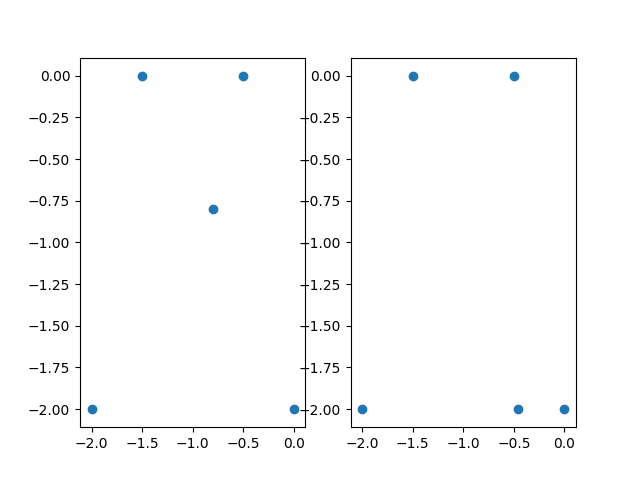

In [6]:
points = np.array([[0.5, 1], [-0.5, 1], [1, -1], [-1, -1], [0.2, 0.2]])

points = points-1

hull = ConvexHull(points, qhull_options='Qt')

direct = np.array([0.2, -0.7])

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(points[:, 0], points[:, 1])

alpha = rayHullIntersect3(points[-1, :], direct, hull)

points[-1] = points[-1] + alpha*direct

ax2.scatter(points[:, 0], points[:, 1])

In [7]:
# Hyperparameters

# Starting F and G polynomials
Fterms = np.random.uniform(low=-1, high=1, size=(16, 3))
Gterms = np.random.uniform(low=-1, high=1, size=(16, 3))

num_samples = 50
epochs = 500000

initial_dropout_rate = 0.5#127/128
dropout_change = 0.9999995

growth_probability = 0.001#.01
remove_probability = 0.001#.1

r1 = 0.5 # Radius of inner circle

# Data function
#r1 = 0.2
#data_func = lambda n: data_gen2.harderXor(n, r1=0.2, alpha=np.sqrt(2)-1)
data_func = lambda n: data_gen2.circles(n, r1)

doF = True

In [8]:
# Set up validation and plotting sets
thing = 101
x = np.linspace(-1, 1, thing)
y = np.linspace(-1, 1, thing)

X, Y = np.meshgrid(x, y)

x = np.reshape(X, thing**2)
y = np.reshape(Y, thing**2)

r1sqr = r1**2
r2sqr = 2*r1sqr
r3sqr = 3*r1sqr

X_test = np.vstack((x, y)).T

indices = X_test[:, 0]**2 + X_test[:, 1]**2 < r1sqr
X_trainCirc = X_test[indices, :]
y_trainCirc = np.ones((X_trainCirc.shape[0], 1))

indices = np.logical_and(r2sqr < X_test[:, 0]**2 + X_test[:, 1]**2, X_test[:, 0]**2 + X_test[:, 1]**2 < r3sqr)
X_trainCirc2 = X_test[indices, :]
y_trainCirc2 = -np.ones((X_trainCirc2.shape[0], 1))

X_testCirc = np.vstack((X_trainCirc, X_trainCirc2))
y_testCirc = np.vstack((y_trainCirc, y_trainCirc2))

In [9]:
# Set up circles for plotting

r2 = (np.sqrt(2))*r1
r3 = np.sqrt(r1**2 + r2**2)

circle = Circle((0, 0), r1, color='g', alpha=0.5)
annulus = Wedge((0, 0), np.sqrt(r3sqr), 0, 360, width=np.sqrt(r3sqr)-np.sqrt(r2sqr), color='r', alpha=0.5)

# circle1 = Circle((0.5, 0.5), r1, color='g', alpha=0.5)
# annulus1 = Wedge((0.5, 0.5), r3, 0, 360, width=r3-r2, color='r', alpha=0.5)

# circle2 = Circle((-0.5, 0.5), r1, color='r', alpha=0.5)
# annulus2 = Wedge((-0.5, 0.5), r3, 0, 360, width=r3-r2, color='g', alpha=0.5)

# circle3 = Circle((0.5, -0.5), r1, color='r', alpha=0.5)
# annulus3 = Wedge((0.5, -0.5), r3, 0, 360, width=r3-r2, color='g', alpha=0.5)

# circle4 = Circle((-0.5, -0.5), r1, color='g', alpha=0.5)
# annulus4 = Wedge((-0.5, -0.5), r3, 0, 360, width=r3-r2, color='r', alpha=0.5)


<IPython.core.display.Javascript object>


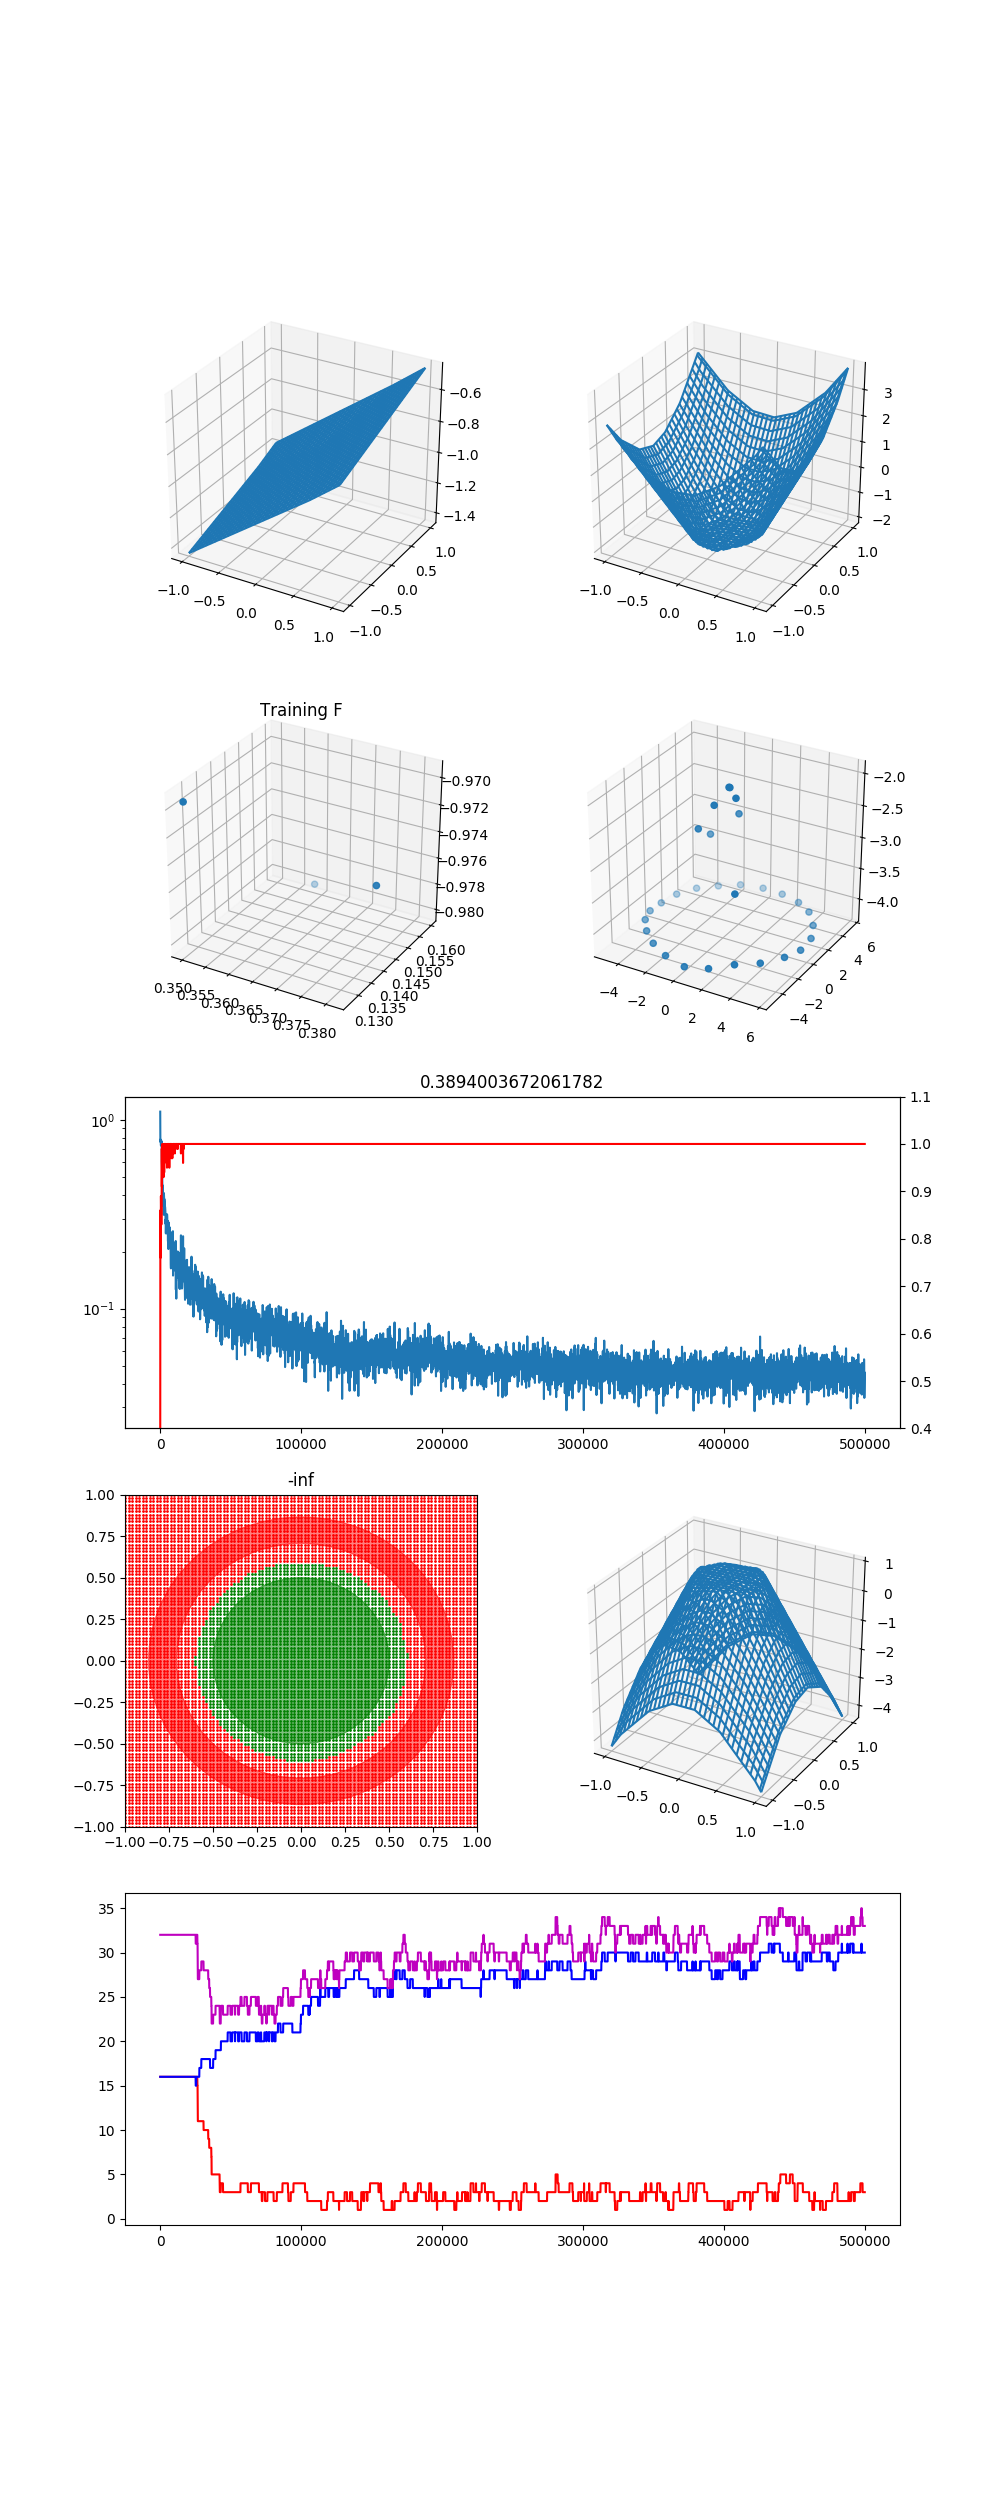

27289.050786972046 seconds to finish


In [10]:
start = time.time()


# Set up plots
fig = plt.figure(figsize=(10, 25))
axWireF = fig.add_subplot(521, projection='3d')
axWireG = fig.add_subplot(522, projection='3d')

axF = fig.add_subplot(523, projection='3d')
axG = fig.add_subplot(524, projection='3d')

axError = fig.add_subplot(513)
axRight = axError.twinx()

axSplit = fig.add_subplot(527)
axFull = fig.add_subplot(528, projection='3d')

axTerms = fig.add_subplot(515)

# Set up metric tracks
errors = []
epoch_list = []
training_acc = []
validation_acc = []
num_fterms_list = []
num_gterms_list = []

maxAlpha = -float('inf')

for epoch in range(epochs):
    # Update the dropout rate
    initial_dropout_rate *= dropout_change
    
    # Get data
    data, _, _ = data_func(num_samples)
    inputData = data[:, 0:-1]
    outputData = data[:, -1]

    # Forward propogation
    Fresult, Gresult, FLocs, GLocs = evaluate_trop(Fterms, Gterms, inputData, dropout_rate=initial_dropout_rate)
    result = Fresult - Gresult

    # Backward propogation
    errorDeriv = outputData - result

    doHullUpdateF = True
    try:
        hullF = ConvexHull(Fterms, qhull_options='Qt')
        #checkFHull = Delaunay(hullF)
    except:
        doHullUpdateF = False
    
        
    doHullUpdateG = True
    try:
        hullG = ConvexHull(Gterms, qhull_options='Qt')
        #checkGHull = Delaunay(Fterms)
    except:
        doHullUpdateG = False
    
    maxs = np.amax(Fterms, axis=0)
    mins = np.amin(Fterms, axis=0)
    Fbox_volume = np.prod(maxs-mins)
    maxs = np.amax(Gterms, axis=0)
    mins = np.amin(Gterms, axis=0)
    Gbox_volume = np.prod(maxs-mins)
    
    if hullF.volume > Fbox_volume:
        doHullUpdateF = False
    if hullG.volume > Gbox_volume:
        doHullUpdateG = False
    
    for i in range(len(errorDeriv)):
        Findex = FLocs[i]
        Gindex = GLocs[i]
        
        # Input data concatenated with 1 for the bias
        thisInput = np.concatenate((inputData[i], np.array([1])))
        thisError = errorDeriv[i]
        thisResult = result[i]
        
        
        fDirect = thisError*thisInput
        fNorm = np.linalg.norm(fDirect)
        
        fDirect = fDirect/fNorm
        
        gDirect = -thisError*thisInput
        gDirect = gDirect/fNorm
        
        if Findex in hullF.vertices or not doHullUpdateF:
            fAlpha = 0
        else:
            fAlpha = rayHullIntersect3(Fterms[Findex], fDirect, hullF)
            
        if Gindex in hullG.vertices or not doHullUpdateG:
            gAlpha = 0
        else:
            gAlpha = rayHullIntersect3(Gterms[Gindex], gDirect, hullG)
        
        fAlpha = max(0.001*fNorm, fAlpha/len(errorDeriv))
        
        gAlpha = max(0.001*fNorm, gAlpha/len(errorDeriv))
        
        #fAlpha = 0.001*fNorm
        #gAlpha = 0.001*fNorm
        
        if doF:
            Fterms[Findex] = Fterms[Findex] + fAlpha*fDirect
        else:
            Gterms[Gindex] = Gterms[Gindex] + gAlpha*gDirect
        
        
    # Evaluate on the validation set
    Fresult, Gresult, FLocs, GLocs = evaluate_trop(Fterms, Gterms, X_test, dropout_rate=0)
    result = Fresult-Gresult
    #validationPercent = np.sum((result.reshape((-1, 1)) > 0) == (y_testCirc > 0))/(len(y_testCirc))


    # See which terms were not used on the validation set
    Fremove = set(range(Fterms.shape[0])) - set(np.unique(FLocs))
    Gremove = set(range(Gterms.shape[0])) - set(np.unique(GLocs))

    if doF:
        # Remove Fterms that go unused
        if Fterms.shape[0] > 0 and len(Fremove) > 0 and np.random.uniform(0, 1, 1) < remove_probability and epoch>20000:
            Fterms = np.delete(Fterms, np.random.choice(list(Fremove)), 0)
        # If all Fterms were used, add another
        if Fterms.shape[0] == len(np.unique(FLocs)) and np.random.uniform(0, 1, 1) < growth_probability:
            new_vals = []
            for column in range(Fterms.shape[1]):
                valAvg = (np.amin(Fterms[:, column]) + np.amax(Fterms[:, column]))/2
                valRange = (np.amax(Fterms[:, column]) - np.amin(Fterms[:, column]))/2
                new_vals.append(np.random.uniform(valAvg - 0.5*valRange, valAvg + 0.5*valRange, 1))

            Fterms = np.append(Fterms, np.array(new_vals).reshape((1, 3)), axis=0)
    else:
        # Remove Gterms that go unused
        if Gterms.shape[0] > 0 and len(Gremove) > 0 and np.random.uniform(0, 1, 1) < remove_probability and epoch>20000:
            Gterms = np.delete(Gterms, np.random.choice(list(Gremove)), 0)
        # If all Gterms were used, add another
        if Gterms.shape[0] == len(np.unique(GLocs)) and np.random.uniform(0, 1, 1) < growth_probability:
            new_vals = []
            for column in range(Fterms.shape[1]):
                valAvg = (np.amin(Gterms[:, column]) + np.amax(Gterms[:, column]))/2
                valRange = (np.amax(Gterms[:, column]) - np.amin(Gterms[:, column]))/2
                new_vals.append(np.random.uniform(valAvg - 0.5*valRange, valAvg + 0.5*valRange, 1))
            Gterms = np.append(Gterms, np.array(new_vals).reshape((1, 3)), axis=0)
        
    if (epoch+1) % 1000 == 0:
        doF = not doF
    
    
    if (epoch+1) % 100 == 0 or epoch == 0:
        axWireF.clear()
        axWireG.clear()
        axF.clear()
        axG.clear()
        axError.clear()
        axSplit.clear()
        axFull.clear()
        axRight.clear()
        axTerms.clear()
        
        # Calculate training accuracy
        Fresult, Gresult, FLocs, GLocs = evaluate_trop(Fterms, Gterms, inputData, dropout_rate=0)
        result = Fresult - Gresult
        training_acc.append(np.sum((result > 0) == (outputData > 0))/(len(outputData)))
        errors.append(np.mean(np.power(outputData - result, 2)))
        epoch_list.append(epoch+1)
        num_fterms_list.append(Fterms.shape[0])
        num_gterms_list.append(Gterms.shape[0])
        
        # Evaluate on the validation set
        #Fresult, Gresult, FLocs, GLocs = evaluate_trop(Fterms, Gterms, X_testCirc, dropout_rate=0)
        #result = Fresult-Gresult
        #validationPercent = np.sum((result.reshape((-1, 1)) > 0) == (y_testCirc > 0))/(len(y_testCirc))
        #validation_acc.append(validationPercent) 
        
        axSplit.add_artist(circle)
        axSplit.add_artist(annulus)
        
#         axSplit.add_artist(circle1)
#         axSplit.add_artist(annulus1)
#         axSplit.add_artist(circle2)
#         axSplit.add_artist(annulus2)
#         axSplit.add_artist(circle3)
#         axSplit.add_artist(annulus3)
#         axSplit.add_artist(circle4)
#         axSplit.add_artist(annulus4)
        
        Fresult, Gresult, FLocs, GLocs = evaluate_trop(Fterms, Gterms, X_test, dropout_rate=0)
        result = Fresult-Gresult
        
        axFull.plot_wireframe(X, Y, result.reshape(X.shape))

        Fresult2, Gresult2, FLocs2, GLocs2 = evaluate_trop(Fterms, Gterms, X_test, dropout_rate=0)
        result = Fresult2 - Gresult2
        
        data_gen2.plotClassifierDataAlt(X_test, result, plot=(fig, axSplit))
        axSplit.set_title(maxAlpha)
        
        axWireF.plot_wireframe(X, Y, Fresult2.reshape(X.shape))
        axWireG.plot_wireframe(X, Y, Gresult2.reshape(X.shape))
        
        axF.scatter(Fterms[:, 0], Fterms[:, 1], zs=Fterms[:, 2])
        axG.scatter(Gterms[:, 0], Gterms[:, 1], zs=Gterms[:, 2])
        
        if doF:
            axF.set_title('Training F')
        else:
            axG.set_title('Training G')
        
        axError.semilogy(epoch_list, errors)
        
        axError.set_title(initial_dropout_rate)
        
        axRight.plot(epoch_list, training_acc, 'r')
        #axRight.plot(epoch_list, validation_acc, '--', c='m')
        axRight.set_ylim([0.4, 1.1])
        #axError.set_xlim([0, epochs])
        
        axTerms.plot(epoch_list, num_fterms_list, 'r')
        axTerms.plot(epoch_list, num_gterms_list, 'b')
        axTerms.plot(epoch_list, [num_fterms_list[i] + num_gterms_list[i] for i in range(len(num_fterms_list))], 'm')
        
        fig.canvas.draw()
        fig.canvas.flush_events()

print(time.time() - start, 'seconds to finish')